# IC3D generated image error analysis

In [1]:
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
# this csv file is all cells, with 1000 latent space samples per cell
csv_file = "/root/projects/pytorch_integrated_cell/test_aaegan/aaegan3Dv5_128D/struct_model/var_test_testing/all_dat.csv"
df = read_csv(csv_file)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  `Unnamed: 0` = col_integer(),
  img_index = col_integer(),
  data_provider_index = col_integer(),
  embedding_data_provider_index = col_integer(),
  embedding_train_or_test = col_character(),
  label = col_character(),
  path = col_character(),
  train_or_test = col_character(),
  tot_inten = col_double(),
  tot_inten_recon = col_double(),
  mse_orig = col_double(),
  mse_recon = col_double(),
  pearson_orig = col_double(),
  pearson_recon = col_double()
)


In [4]:
# remove rows with missing data
df = df[complete.cases(df), ]

# remove empty cols
drop_cols = c("X1", "Unnamed: 0")
df = select(df,-one_of(drop_cols))

# change data types of some cols
df %>%
    mutate(
        train_or_test=as.factor(train_or_test),
        embedding_train_or_test=as.factor(embedding_train_or_test),
        label=as.factor(label)
    ) -> df

In [5]:
# rename cols and move from mse to rmse

df %>%
    rename(
        img_dp_index=data_provider_index,
        latent_dp_index=embedding_data_provider_index,
        latent_phase=embedding_train_or_test,
        img_phase=train_or_test,
        img_path=path,
        img_label=label
    ) %>%
    mutate(rmse_orig=sqrt(mse_orig)) %>%
    mutate(rmse_recon=sqrt(mse_recon)) %>%
    select(-one_of("mse_orig","mse_recon")) ->
    df

In [6]:
# create a master index for the latent inds and a structure label for the latent location

df %>% 
    distinct(img_index,img_dp_index,img_phase,img_label) %>%
    rename(latent_index=img_index,
           latent_dp_index=img_dp_index,
           latent_phase=img_phase,
           latent_label=img_label) %>%
    inner_join(df) ->
    df

Joining, by = c("latent_dp_index", "latent_phase")


In [57]:
df %>% head

latent_index,latent_dp_index,latent_label,latent_phase,img_index,img_dp_index,img_label,img_path,img_phase,tot_inten,tot_inten_recon,pearson_orig,pearson_recon,rmse_orig,rmse_recon
0,0,Alpha actinin,train,21,18,Alpha actinin,20160708_I01_015.czi_5,train,227.5491,369.0044,0.0318835,0.0630173,0.005966334,0.006341810
0,0,Alpha actinin,train,26,22,Alpha actinin,20160708_I01_016.czi_3,train,394.1137,505.5660,0.2101690,0.2520310,0.005556682,0.005559171
0,0,Alpha actinin,train,27,23,Alpha actinin,20160708_I01_016.czi_4,train,255.9216,353.0978,0.1806540,0.1940380,0.004863494,0.005025715
0,0,Alpha actinin,train,36,32,Alpha actinin,20160708_I01_017.czi_6,train,834.3492,952.9771,0.1896990,0.2256790,0.008893522,0.008676007
0,0,Alpha actinin,train,53,46,Alpha actinin,20160708_I01_021.czi_5,train,912.8157,926.9310,0.1832310,0.1539890,0.009799806,0.009926394
0,0,Alpha actinin,train,60,53,Alpha actinin,20160708_I01_023.czi_9,train,470.3334,446.8575,0.0641659,0.0718737,0.006699864,0.006283524


In [68]:
# get aggregate stats (median, median absolute deviation) for reconstruction error of each cell

df %>%
    select(img_index, img_label, img_phase, pearson_orig, pearson_recon, rmse_orig, rmse_recon) %>%
    group_by(img_index, img_label, img_phase) %>%
    summarise_all(funs(median, mad)) ->
    df_stats

df %>%
    select(img_index,tot_inten) %>%
    distinct %>%
    inner_join(df_stats) ->
    df_stats

Joining, by = "img_index"


## Save out best and worst predictions

In [69]:
N=16

df_stats %>%
    select(img_index, img_label, img_phase, pearson_orig_median) %>%
    group_by(img_label, img_phase) %>% top_n(N, pearson_orig_median) ->
    df_best_preds

df_stats %>%
    select(img_index, img_label, img_phase, pearson_orig_median) %>%
    group_by(img_label, img_phase) %>% top_n(N, desc(pearson_orig_median)) ->
    df_worst_preds

In [70]:
df %>% 
    distinct(img_index,img_dp_index,img_phase,img_label) %>%
    inner_join(df_best_preds) -> df_best_preds

df %>% 
    distinct(img_index,img_dp_index,img_phase,img_label) %>%
    inner_join(df_worst_preds) -> df_worst_preds

Joining, by = c("img_index", "img_label", "img_phase")
Joining, by = c("img_index", "img_label", "img_phase")


In [71]:
df_best_preds$Type = "best"
df_worst_preds$Type = "worst"

df_extremal_preds = rbind(df_best_preds, df_worst_preds)

In [72]:
df_best_preds %>% write_csv("best_preds.csv")
df_worst_preds %>% write_csv("worst_preds.csv")
df_extremal_preds %>% write_csv("extremal_preds.csv")

## Plots

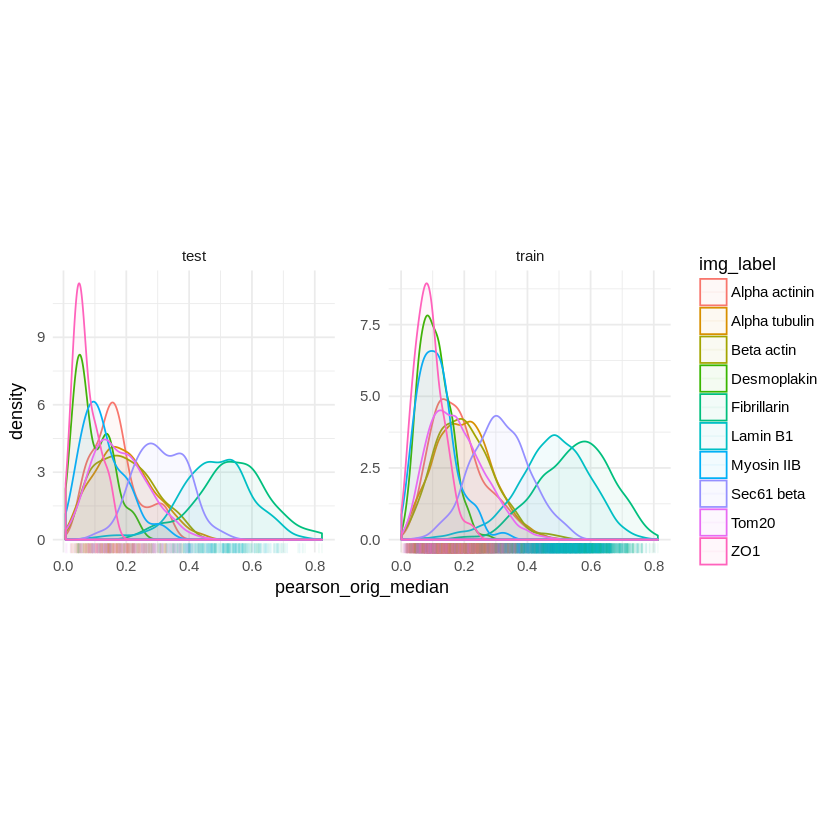

In [73]:
df_stats %>%
    ggplot(aes(x=pearson_orig_median, color=img_label, fill=img_label)) +
    geom_density(alpha=0.05) +
    geom_rug(alpha=0.05) +
    theme_minimal() +
    facet_wrap(~img_phase, scales = 'free') +
    theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines"))

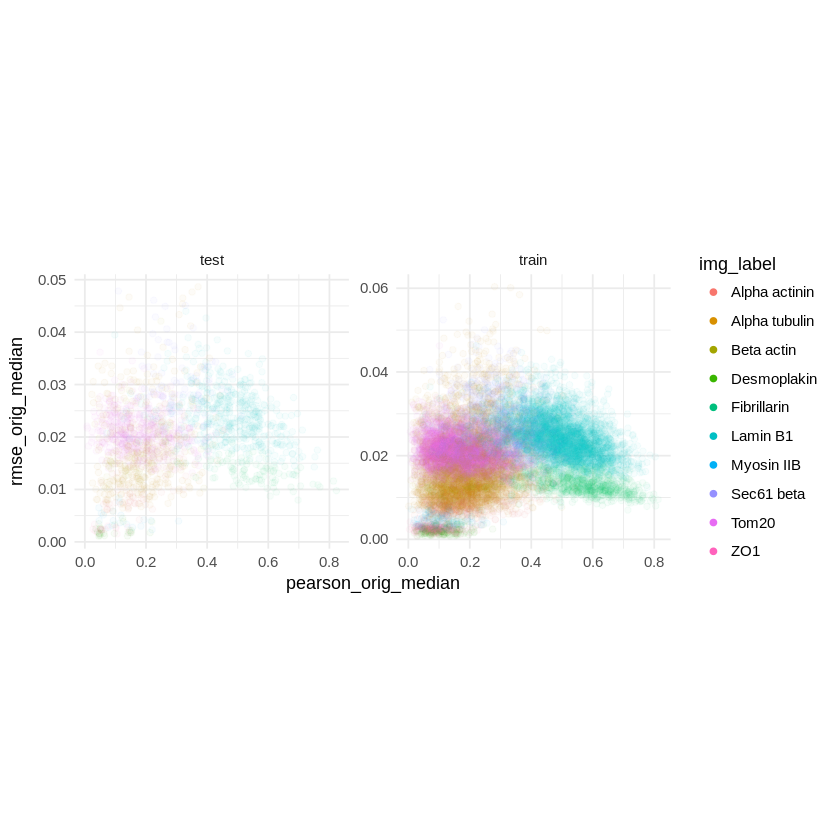

In [74]:
df_stats %>%
    ggplot(aes(x=pearson_orig_median, y=rmse_orig_median, color=img_label, fill=img_label)) +
        geom_point(alpha=0.03) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))

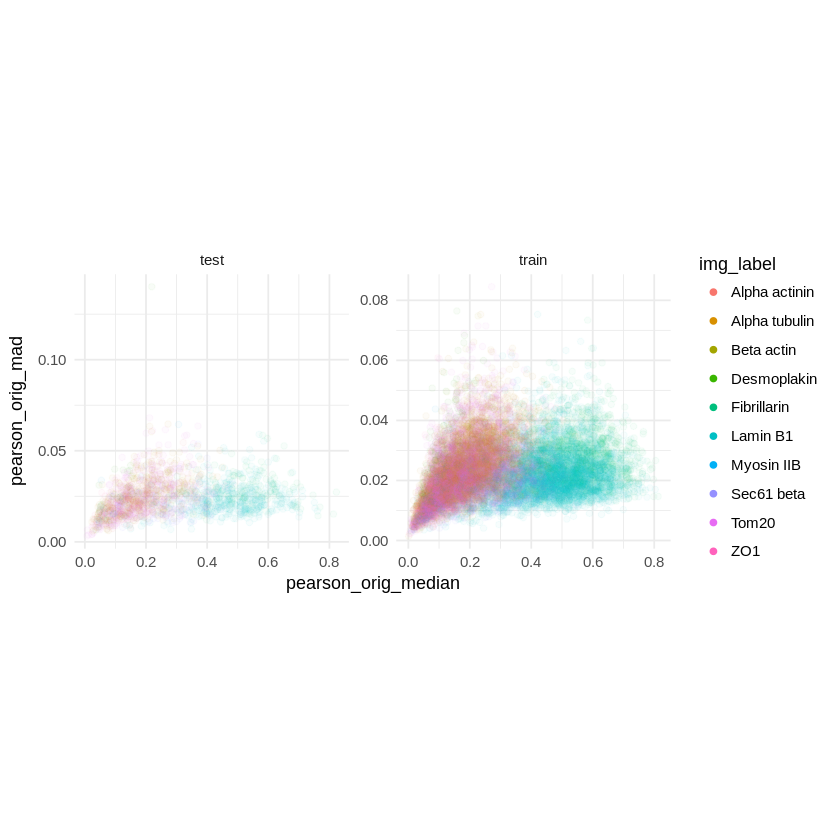

In [76]:
df_stats %>%
    ggplot(aes(x=pearson_orig_median, y=pearson_orig_mad, color=img_label, fill=img_label)) +
        geom_point(alpha=0.03) +
        theme_minimal() +
        theme(aspect.ratio=1) +
        facet_wrap(~img_phase, scales = 'free') +
        guides(colour = guide_legend(override.aes = list(alpha = 1)))